# Nanodegree Engenheiro de Machine Learning

## Projeto Final

### Fábio Corrêa Cordeiro
### Agosto 2018

# Introdução

O presente projeto final consiste na utilização de algoritmos de aprendizado não supervisionados conhecidos como Doc2Vec para representar documentos de um corpus através de vetores (Le et al., 2014). Esses vetores serão utilizados para treinar algoritmos de aprendizado supervisionado e gerar modelos de classificação nos subdomínios de Óleo e Gás. Desta forma será possível identificar quais documentos estão semanticamente relacionados, além de classificá-los nos subdomínios.

Esse projeto é uma evolução do trabalho “Word Embeddings em português para o domínio específico de Óleo e Gás” (Gomes, 2018), disponível em https://github.com/diogosmg/wordEmbeddingsOG. Esse projeto consistiu em testar algoritmos de vetorização de palavras (Mikolov et al., 2013) de forma que fosse possível identificar similaridades semânticas entre palavras de um mesmo domínio de conhecimento.

### Importando as bibliotecas necessárias

In [1]:
import numpy as np
import datetime
import pandas as pd
from collections import Counter
import os
from pathlib import Path
import random
from random import shuffle
import re
import nltk
from  nltk.corpus import stopwords # Import the stop word list
from string import ascii_lowercase
import unicodedata
import gensim
from gensim.models import Word2Vec
from gensim.models.word2vec import PathLineSentences
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from bokeh.models import ColumnDataSource, LabelSet, LayoutDOM, Plot
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.core.properties import Instance, String
from wordcloud import WordCloud #, STOPWORDS
import matplotlib.pyplot as plt

C:\Users\fabio\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Analisando o Corpus

O corpus utilizado é composto por 290 projetos finais (monografias de graduação, dissertações de mestrado e teses de doutorado) do Programa de Recursos Humanos da Agência Nacional do Petróleo, Gás Natural e Biocombustível ([PRH-ANP](
http://www.anp.gov.br/pesquisa-desenvolvimento-e-inovacao/prh-anp-programa-deformacao-de-recursos-humanos/trabalhos-finais-dos-bolsistas)). Esses documentos estavam originalmente em formato PDF que, em alguns casos, haviam sido digitalizados. Foram utilizadas técnicas de reconhecimento de caracteres (OCR - optical character recognition) para extrair os textos para o formato TXT. Todos esses documentos contém, após serem preprocessados, um total 3.308.466 palavras e um vocabulário de 52.880 palavras únicas.

In [2]:
# Os documentos estão na pastas 'PRH'
DIR = 'PRH'
print ('Números de documentos: ',
       len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

Números de documentos:  290


Nas próximas células serão definidas as função para ler os documentos de um determinado arquivo e extrair informações sobre os textos. As informações extraídas são os números de palavras (chamado de tokens) e um contador com as palavras do texto com a sua respectiva frequência.

In [3]:
# Dado um arquivo de entrada, a função retorna o texto contido nesse arquivo
def lerTextoDeArquivo(arquivoEntrada):
    with open(arquivoEntrada, 'r', encoding="UTF-8") as f: #UTF-8
        texto = f.read()
    return texto

In [4]:
# Dado um texto de entrada, a função retorna o número de tokens do texto e 
# uma lista com o vocabulário e frequência das palavras.
def info_corpus(texto):
    word_counts = Counter()
    tokens_totais = 0
    for sent in texto.split():
        #print(sent)
        tokens_totais += sent.count(' ') + 1
        word_counts[sent] += 1
    return(tokens_totais, word_counts)

O corpus que iremos trabalhar possui 290 documentos. Inicialmente vamos analisar apenas um documento como exemplo, o arquivo "PRH/20120904-MONOGRAFIA_0.txt". Para esse exemplo o número total de palavras (também chamado de tokens) é 20.402 e o tamanho do vocabulário (tokens únicos) é 5.270.

In [5]:
# Lendo e extraído informações do arquivo
doc =  "PRH/20120904-MONOGRAFIA_0.txt"
texto = lerTextoDeArquivo(doc)
info_texto = info_corpus(texto)

print('Total de tokens analisados: ', "{:,}".format(info_texto[0]))
print('Tamanho do Vocabulário: ', "{:,}".format(len(info_texto[1])))

Total de tokens analisados:  20,395
Tamanho do Vocabulário:  5,271


Os documentos em geral possuem a característica de possuirem relativamente poucas palavras que aparecem muitas vezes no texto, enquanto existem uma quantidade muito grande de palavras que são raras. Podemos notar essa característica ao plotar um gráfico com a frequência de cada palavra no texto e verificar o efeito de "cauda longa".

In [6]:
# PLotando a frequência das palavras mais comuns
# Refinimos uma fução para plotar um gráfico que recebe um contador 
# com a frequência das palavras e o númeor de palavras mais comuns desejado 

def frequencia_palavras(frequency,n_common):                   # Número de palavras a ser plotado

    x_line = range(1, n_common+1)                              # Definindo eixo x
    y_line = []            

    for n in range(n_common):
        y_line.append(frequency.most_common(n_common)[n][1])   # Definindo eixo y

    p = figure(title="Frequência das palavras", 
               plot_width=800, plot_height=400, 
               y_axis_label="Frequência", 
               x_axis_label="Palavras mais comuns")
    p.line(x=x_line, y=y_line)

    output_notebook()

    show(p)
    
frequencia_palavras(info_texto[1],1000)

Loading BokehJS ...

Para visualizar as palavras mais frequentes vamos plotar uma núvem de palavras onde o tamanho das palavras está relacionado à frequência.

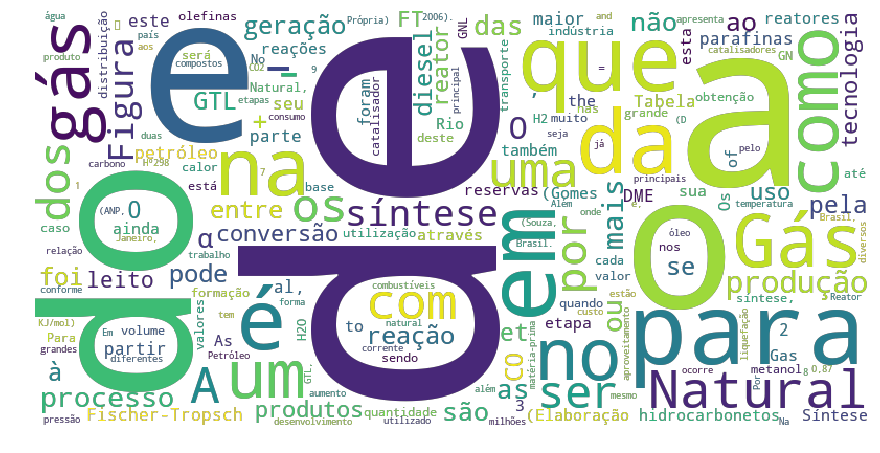

In [7]:
# Função para gerar uma núvem de palavras de um texto
    
def generate_wordcloud(frequency):
    plt.figure(figsize=(15,10))
    wordcloud = WordCloud(width=800,
                          height=400,
                          background_color = None,
                          mode = "RGBA").generate_from_frequencies(frequency)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

generate_wordcloud(info_texto[1])

O próximo passo é a identificação do número de tokens e o vocabulário total de todos os documentos. Para isso é necessário unificar todos os documentos para analisá-los em conjunto. Os documentos serão unificados em: 'corpus_unificado\corpus_unificado.txt'.

In [8]:
momentoInicial = datetime.datetime.now() # Inicia um contador de tempo

# Define os arquivos de entrada e saída
extensao = "*.txt"
pastaentrada =  "PRH" 
pastaSaida = "corpus_unificado" 
arquivoSaida = os.path.join(pastaSaida, 'corpus_unificado.txt')

# cria a pasta de saida, se nao existir
if not os.path.exists(pastaSaida):
    os.makedirs(pastaSaida)

# Iterando os arquivos da pasta de entrada
pastaArquivosCorpus = Path(pastaentrada).glob(extensao)

for path in pastaArquivosCorpus: 
    path_arquivo = str(path) 
    #print("Lendo o arquivo ", path_arquivo)
    
    texto = ''
    with open(path_arquivo, 'r', encoding="UTF-8") as f:
        texto = f.read() #Lendo os arquivos da pasta de entrada
    
    with open(arquivoSaida, 'a', encoding='utf8') as fp:
        fp.write('%s' % texto) #Escrevendo o texto no arquivo de saída
        
momentoFinal = datetime.datetime.now() #Encerrando o contador do tempo
print("Tempo total decorrido: ", momentoFinal - momentoInicial)

Tempo total decorrido:  0:00:41.472244


Após a unificação dos documentos no arquivo 'corpus_unificado\corpus_unificado.txt' iremos identificar as informações do corpus total que será trabalhado.

In [10]:
momentoInicial = datetime.datetime.now()    # Inicia um contador de tempo

# Lendo e extraído informações do arquivo
doc =  'corpus_unificado\corpus_unificado.txt'
texto = lerTextoDeArquivo(doc)
info_n_textos = info_corpus(texto)

print('Total de tokens analisados: ', "{:,}".format(info_n_textos[0]))
print('Tamanho do Vocabulário: ', "{:,}".format(len(info_n_textos[1])))

momentoFinal = datetime.datetime.now()    #Encerrando o contador do tempo
print("Tempo total decorrido: ", momentoFinal - momentoInicial)

Total de tokens analisados:  5,883,758
Tamanho do Vocabulário:  381,109
Tempo total decorrido:  0:00:11.476631


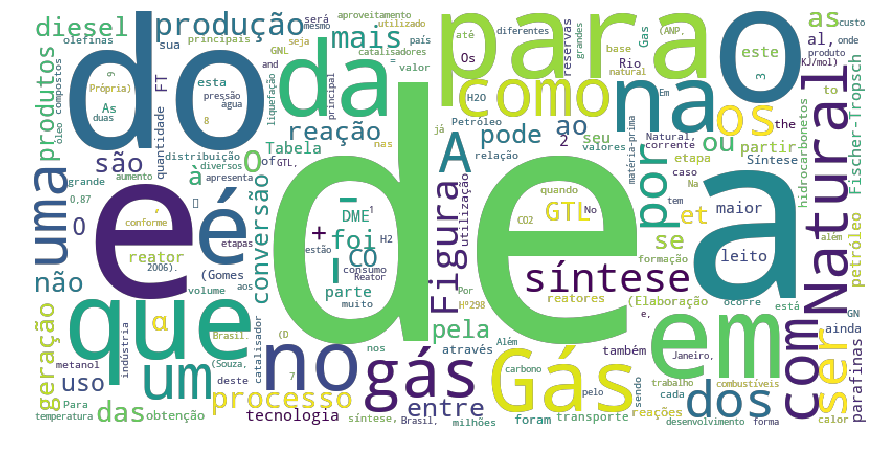

In [11]:
# Gerando a núvem de palavras de todos os documentos
generate_wordcloud(info_texto[1])

O corpus que estamos trabalhando é composto por cerca de 5,8 milhões de palavras e um vocabulário de aproximadamente 381 mil palavras diferente. No entanto, ao olharmos para as palavras mais comuns notamos que, em sua grande maioria, são compostas por termos com pouco significado semântico, ou seja, trazem pouca informação sobre o conteúdos dos textos de onde foram retiradas. É comum encontrar nas palavras mais frequentes artigos, preposições e pronomes. Também é possível notar que "a" e "A" são tratadas como duas palavras diferentes. Os números e caracteres especiais também estão presente nesse nosso vocabulário inicial.

Portanto, o próximo passo é realizar um preprocessamento do texto antes de começar a trabalhar com ele.

### Preprocessando os documentos

Antes de começarmos a etapa de vetorização das palavras e dos textos é necessário preprocessar o texto original. Nesse preprocessamento foram extraidas as palavras com pouca representação semântica, além de tentar minimizar os efeitos de possíveis erros de digitalização.

A etapa de preprocessamento contou com as seguintes etapas:
* Substituir todas as letras pelo seu formato minúsculo. Dessa forma não há diferenciação das palavras grafadas em maiúsculo ou minúsculo.
* Retirar todas as acentuações, pois essa é uma grande fonte de problemas nos documentos digitalizados.
* Eliminar os caracteres de pontuação e números, já que esses podem atrapalhar na identificação da semântica pelos métodos utilizados.
* Por fim, subtrair as palavras com pouco significado semântico, as chamadas "stopwords".

In [8]:
# Dado um texto a função retorna o texto preprocessado
def preprocessando (texto):
    # Unificando caracteres maiúsculo e minísculo
    texto = str(texto.lower())
    
    # Unificando palavras acentuaadas e não acentuadas
    nfkd_form = unicodedata.normalize('NFKD', texto)
    texto= u"".join([c for c in nfkd_form if not unicodedata.combining(c)])
    
    # Primeiro, adicionando espaços aos caracteres de pontuacao
    texto = re.sub('([.,!?()/])', r' \1 ', texto)
    texto = re.sub('\s{2,}', ' ', texto)
    
    # Retirando os caracteres de pontuação e numeros (mantendo apenas os caracteres de ponto, final de sentença)
    pontuacao = '["#%\'()*+,-/:;<=>@\[\]^_`{|}~1234567890’”“′‘\\\•]'
    texto = ''.join([c for c in texto if c not in pontuacao])
    
    return (texto)

As "stopwords" são as palavras que aparecem com maior frequência nos textos em geral. Por elas ocorrerem com uma probabilidade maior em qualquer documento, a ocorrência delas em um documento específico acrescenta pouca informação nova. Se observarmos as palavras mais frequentes no nosso corpus vamos identificar a presença de vários artigos e preposições.

In [9]:
# 20 palavras mais comuns no vocabulário
print (info_n_textos[1].most_common(20))
frequencia_palavras(info_n_textos[1],20)

NameError: name 'info_n_textos' is not defined

Para extrair as "stopwords" vamos recorrer às bibliotecas da “Natural Languages Toolkit” (NLTK) com stopwords em português, inglês e espanhol. Também iremos considerar "stopwords" os caracteres únicos, ou seja, as letras do alfabeto de "a" a "z". Nesse caso, as letras isoladas, em geral, representam quebras de palavras no processo de digitalização. Também acrescentamos uma lista com os erros mais comuns identificados.

In [10]:
# Importando as bibliotecas de stopwords
# nltk.download('stopwords') 

In [10]:
# Mapeando stopwords com NLTK
stopwordsPortugues = stopwords.words("portuguese")
stopwordsIngles = stopwords.words("english")
stopwordsEspanhol = stopwords.words("spanish")
caracteres_unicos = [c for c in ascii_lowercase]
palavrasIncorretasComuns = ['–', '&', '\uf0b7', '−', 'cid']

# mais rapido buscar set do que list
vocabulario_palavras_ignoradas = set(stopwordsPortugues + 
                                     stopwordsIngles + 
                                     stopwordsEspanhol + 
                                     caracteres_unicos + 
                                     palavrasIncorretasComuns)

As bibliotecas de "stopwords" trazem as palavras com acentuação, mas o nosso texto sofrerá preprocessamento para extrair os acentos. Dessa forma é necessário que façamos o mesmo preprocessamento do texto nas "stopwords" que importamos da biblioteca NLTK.

In [11]:
# Passar as "stopwords" pelo preprocessamento
vocabulario_processado_palavras_ignoradas = set()
for palavra in vocabulario_palavras_ignoradas:
    vocabulario_processado_palavras_ignoradas.add(preprocessando(palavra))

Finalmente vamos criar uma função para extrair as stopwords de um determinado texto.

In [12]:
# Dado um texto a função retorna o texto sem "stopwords"
def retirar_stopwords (texto):
    sentenca_sem_stopwords = [w for w in texto.split() if not w in vocabulario_processado_palavras_ignoradas]
    texto = " ".join( sentenca_sem_stopwords )
    return (texto)

Primeiramente será feito o preprocessado do texto que unificou todo o corpus. Podemos observar o crescimento do número de tokens (7,3 milhões), já que os pontos finais agora se tornaram um token separado e consequentemente o token mais frequente. Por outro lado o tamanho do vocabulário (115 mil) é bastante reduzido após a preprocessamento.

In [16]:
momentoInicial = datetime.datetime.now() # Inicia um contador de tempo

# preprocessando o texto
texto_preprocessado = preprocessando (texto)
# Extraindo as informações de tokens e vocabulário de palavras
info_n_texto_processado = info_corpus(texto_preprocessado)

print('Total de tokens analisados: ', "{:,}".format(info_n_texto_processado[0]))
print('Tamanho do Vocabulário: ', "{:,}".format(len(info_n_texto_processado[1])))

momentoFinal = datetime.datetime.now() #Encerrando o contador do tempo
print("Tempo total decorrido: ", momentoFinal - momentoInicial)

Total de tokens analisados:  7,301,178
Tamanho do Vocabulário:  115,667
Tempo total decorrido:  0:03:08.467003


A etapa seguinte é extraír as "stopwords" do texto. Neste caso podemos observar uma grande diminuição de tokens (5 milhões) com um decréscimo ínfimo no vocabulário (115 mil).

In [17]:
momentoInicial = datetime.datetime.now()   # Inicia um contador de tempo

# Eliminação de "stopwords"
texto_preprocessado = retirar_stopwords (texto_preprocessado)
# Extraindo as informações de tokens e vocabulário de palavras
info_n_texto_processado = info_corpus(texto_preprocessado)

print('Total de tokens analisados: ', "{:,}".format(info_n_texto_processado[0]))
print('Tamanho do Vocabulário: ', "{:,}".format(len(info_n_texto_processado[1])))

momentoFinal = datetime.datetime.now()  #Encerrando o contador do tempo
print("Tempo total decorrido: ", momentoFinal - momentoInicial)

Total de tokens analisados:  5,069,367
Tamanho do Vocabulário:  115,276
Tempo total decorrido:  0:00:08.229617


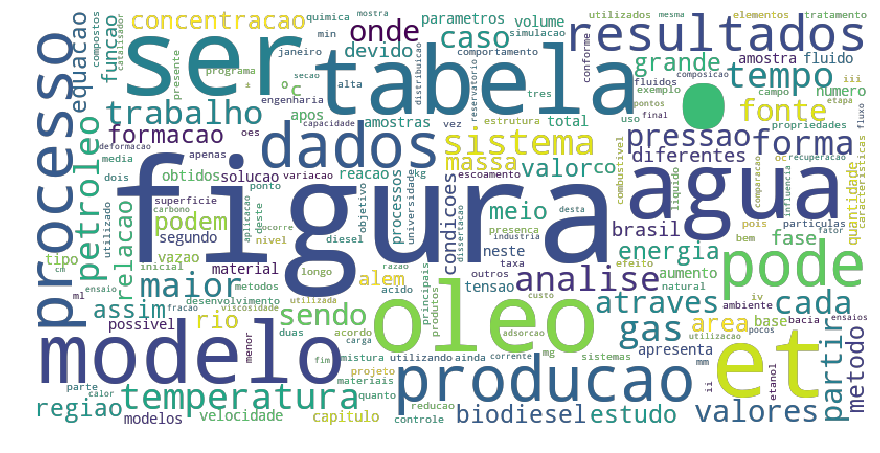

In [18]:
# Gerando a núvem de palavras de todos os documentos
generate_wordcloud(info_n_texto_processado[1])

Por fim, o formato do texto será alterado para apresentar apenas uma sentença por linha. Esse formato serve para facilitar a implementação do algoritmo de vetorização de palavras. Na implementação realizada por Noorralahzadeh et al. (2018), foi possível notar que as palavras e temas que entravam primeiro no treinamento do modelo influenciavam mais que as últimas. Desta forma, as sentenças foram misturadas além de excluir as sentenças com menos de 3 palavras.

In [13]:
# Unificando quebras de linha e colocando uma frase por linha
def sentenca_por_linha (texto):    
    texto = texto.replace('\n', ' ').replace('\r', '') # Unificando quebra de linha
    texto = texto.replace('?','.').replace('!','.') # Equalizando todos os pontos finais
    lista_com_quebra_de_linha = texto.split('.') # Colocando todas as frases em uma lista
    shuffle(lista_com_quebra_de_linha) # Misturando as frases
    # Unindo sentenças com mais de 3 tokens
    texto = '\n'.join([sentenca for sentenca in lista_com_quebra_de_linha if len(sentenca.split(' ')) > 3]) 
    return (texto)

In [19]:
# Separando as sentenças por linha e misturando
texto_preprocessado = sentenca_por_linha (texto_preprocessado)

# Salvando o arquivo final em "corpus_unificado\corpus_unificado_preprocessados.txt"
with open("corpus_unificado\corpus_unificado_preprocessados.txt", 'a', encoding='utf8') as fp:
    fp.write('%s' % texto_preprocessado)

O mesmo preprocessamento que fizemos com o corpus unificado será feito com cada um dos documentos individualmente. Na pasta corpus_preprocessado serão gravados os arquivos prontos para serem utilizados pelos algoritmos de vetorização.

In [24]:
momentoInicial = datetime.datetime.now()   # Inicia um contador do tempo

extensao = "*.txt"                  # Extensão do arquivo de saída
pastaentrada =  "PRH"               # Pasta onde estão os arquivos de entrada
pastaSaida = "corpus_preprocessado" # Pasta onde serão gravados os arquivos preprocessados

# cria a pasta de saida, se nao existir
if not os.path.exists(pastaSaida):
    os.makedirs(pastaSaida)

# Define as pastas de entrada e saída
pastaArquivosCorpus = Path(pastaentrada).glob(extensao)
pastaSaída = Path(pastaSaida)

# Iterando os arquivos da pasta atual
for path in pastaArquivosCorpus:

    path_arquivo = str(path) # because path is object not string
    
    #print("Lendo o arquivo ", path_arquivo)
    
    texto = ''
    with open(path_arquivo, 'r', encoding="UTF-8") as f:
        texto = f.read()
    
    # Aplicando as funções de preprocessamento
    texto = preprocessando (texto) 
    texto = retirar_stopwords (texto)
    #texto = sentenca_por_linha (texto)
    
    # Definindo os arquivos de saída e gravando os documentos
    arquivoSaída = os.path.basename(path)
    arquivoSaída = os.path.join(pastaSaida, arquivoSaída)      
    with open(arquivoSaída, 'a', encoding='utf8') as fp:
        fp.write('%s' % texto)
        
momentoFinal = datetime.datetime.now() #Encerrando o contador do tempo
print("Tempo total decorrido: ", momentoFinal - momentoInicial)

Tempo total decorrido:  0:01:02.507402


# Modelos de Vetorização de Palavras

Nesta sessão são explorados os modelos de vetorização de palavras e documentos. Os modelos utilizados são o Word2Vec (Mikolov et al, 2013) e o Doc2Vec (Le et al, 2014). Esses modelos buscam representar cada termo do vocabulário (Word2Vec), ou cada documento de um corpus (Doc2Vec), em um vetor. A distância entre esses vetores tende a representar a distância semântica dessas palavras ou documentos.

Primeiramente analisamos o modelo de vetorização de palavras utilizando o arquivo com o corpus unificado ("corpus_unificado_preprocessados.txt"). Usamos os hiperparâmetros utilizados por Nooralahzadeh (2018). Em seu trabalho Nooralahzadeh analisou os efeitos dos hiperparâmetro em um corpus do domínio Óleo & Gás em inglês. A única alteração que fizemos nos hiperparâmetros foi diminuir a dimensão dos vetores finais de 400 para 100, pois o nosso corpus é relativamente pequeno. Utilizamos o mesmo tamanho dos vetores escolhido para o nosso trabalho anterior (Gomes, 2018).

In [35]:
print('Iniciando treinamento em Word2Vec')
momentoInicial = datetime.datetime.now()   # Iniciando o contador do tempo

pathCorpus = "corpus_unificado"  # Caminho do documento que será vetorizado
Corpus = os.path.join(pathCorpus, 'corpus_unificado_preprocessados.txt')
sentences = PathLineSentences(Corpus)

model = Word2Vec(sentences, size=100) #Gerando modelo Word2Vec

momentoFinal = datetime.datetime.now()   # Encerrando o contador do tempo
print("Tempo total decorrido: ", momentoFinal - momentoInicial)

Iniciando treinamento em Word2Vec
Tempo total decorrido:  0:00:38.607654


Após treinar o modelo, cada palavra do vocabulário é representada por um vetor com 100 dimensões. Vejamos como ficou representado a palavra "petroleo".

In [36]:
# Vetor correspondente a uma das palavras do documento
model.wv['petroleo']  

array([-0.05485432,  1.2870672 , -0.9074549 , -0.75738883, -1.5341176 ,
       -1.7886276 , -2.8629293 ,  3.9180632 ,  2.2304301 , -1.5921545 ,
       -0.96457964,  0.09794594,  1.6311808 ,  1.3033826 ,  0.8627463 ,
       -1.6035248 ,  0.5230779 , -0.04435697,  2.5169725 , -0.3471934 ,
        0.96219015,  2.0361526 , -1.5411804 , -2.6811671 , -2.9765406 ,
        1.3189119 , -0.920007  ,  1.6036842 ,  2.6712022 , -1.5313547 ,
       -0.7667641 , -0.17255494,  1.4567387 ,  1.3800603 ,  1.751126  ,
       -0.03030156, -1.4512731 , -2.4137812 , -1.2744452 , -0.40015882,
        0.09578744,  2.3606884 , -0.50612146, -3.1222994 ,  1.2423648 ,
        2.9914339 ,  1.2525927 , -2.0944643 , -0.0934673 ,  0.01260688,
       -0.5298767 ,  0.0748494 , -0.31979686,  1.6195575 ,  1.3099916 ,
       -0.9990859 , -2.0419219 , -0.9264828 ,  0.5663647 , -0.54542094,
        1.0931699 ,  0.7655173 , -0.3494499 ,  0.58576334, -0.26430222,
       -2.5559034 ,  0.2117136 , -5.66095   ,  1.3169794 ,  1.41

Outra característica dos modelos vetoriais é a possibilidade, dado uma palavra, de identificar os vetores mais próximos. Vejamos as 10 palavras mais próximas do termo "petroleo".

In [37]:
# Palavras com vetores mais próximos 
model.wv.most_similar("petroleo", topn=10)  

C:\Users\fabio\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('petrolifera', 0.6956394910812378),
 ('oleo', 0.6196221113204956),
 ('exploracao', 0.6120014786720276),
 ('secundaria', 0.6029049158096313),
 ('petroquimica', 0.5961840152740479),
 ('presal', 0.5905599594116211),
 ('oleos', 0.5713956356048584),
 ('primaria', 0.5589098930358887),
 ('natural', 0.5576205253601074),
 ('reservatorios', 0.5557948350906372)]

Para ter uma ideia melhor de como os termos estão relacionados podemos visualizá-los em um único gráfico. Como o vocabulário é muito grande para plotar todas as palavras, escolhemos as 1000 palavras mais frequentes.

In [38]:
# Separando os vetores das palavras mais comuns
most_common = info_n_texto_processado[1].most_common(1000)

vocabulario = list()
vetores = list()

# Iterando para extrair uma lista com os termos e outra lista com os vetores
for word in most_common:
    palavra = word[0]
    if (palavra in model.wv.vocab):
        vocabulario.append(palavra)
        vetores.append(model.wv.word_vec(palavra))   

NameError: name 'info_n_texto_processado' is not defined

Para plotar as palavras em um gráfico de duas dimensões tendo vetores de 100 dimensões precisamos aplicar algum algoritmo para reduzir a dimensionalidade. Utilizamos o algoritmo t-SNE para reduzir a dimensionalidade dos vetores.

In [ ]:
# Reduzindo de 100 dimensões para 2 usando tSNE para permitir a plotagem
tsne = TSNE(n_components=2, random_state=0, perplexity=12,early_exaggeration=10  )
embed_tsne = tsne.fit_transform(vetores)

In [ ]:
#Definindo uma função que recebe os vetores já reduzidos para duas dimensões e plota o gráfico
def scater_plot(embed_tsne, vocabulario):
    p = figure(tools="pan,wheel_zoom,reset",#save",
               toolbar_location="above",
               title=" ",
               plot_width=800, 
               plot_height=500)

    source = ColumnDataSource(data=dict(x1=embed_tsne[:,0],
                                        x2=embed_tsne[:,1],
                                        names=vocabulario))

    p.scatter(x="x1", y="x2", size=8, source=source)

    labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                      text_font_size="8pt", text_color="#555555",
                      source=source, text_align='center')
    p.add_layout(labels)
    output_notebook()
    show(p)
    return()

# Plotando o grafico
scater_plot(embed_tsne, vocabulario)

O gráfico é formado por uma núvem com as 1000 palavras mais comuns do vocabulário. Essas palavras foram plotadas de acordo com a proximidade dos seus vetores. Ao navegarmos por essa núvem utilizando o zoom podemos notar algumas relações semânticas entre os termos que compõem um mesmo aglomerado. Essa proximidade semântica é diretamente relacionada com corpus onde o documento foi treinado (Gomes, 2018).

Para representar melhor às distâncias, tanto vetorial quanto semântica, escolhemos os termos "empresa", "universidade", "fermentacao", "petroleo". Para cada um dos quatro termos buscamos os 20 vetores mais próximos e plotamos todos em um gráfico de duas dimensões.

In [ ]:
# Buscando no modelo Word2Vec as 20 palavras mais similares para cada um dos termos selecionados
N_tupla1 = model.wv.most_similar("empresa", topn=20) 
N_tupla2 = model.wv.most_similar("universidade", topn=20)
N_tupla3 = model.wv.most_similar("fermentacao", topn=20)
N_tupla4 = model.wv.most_similar("petroleo", topn=20)
N_tupla = N_tupla1 + N_tupla2 + N_tupla3 + N_tupla4

# Incluindo todas as palavras que serão plotadas em uma única lista
N_word = list(["empresa",          # Incluindo os termos escolhidos
               "universidade", 
               "fermentacao", 
               "petroleo"])  
for word in N_tupla:               # Incluindo os 20 termos mais próximos de cada termos escolhido
    N_word.append(word[0])
    
vocabulario2 = list()
vetores2 = list()

# Iterando para extrair uma lista com os termos e outra lista com os vetores
for word in N_word:
    palavra = word
    if (palavra in model.wv.vocab):
        vocabulario2.append(palavra)
        vetores2.append(model.wv.word_vec(palavra));

Novamente é necessário reduzir a dimensionalidade dos vetores para poder plotar o gráfico.

In [ ]:
tsne = TSNE(n_components=2, random_state=0, perplexity=12,early_exaggeration=10  )
embed_tsne2 = tsne.fit_transform(vetores2)

In [ ]:
scater_plot(embed_tsne2, vocabulario2)

# Modelos de Vetorização de Documentos

A próxima etapa consiste em usar o algoritmo Doc2Vec para representar cada documento como um vetor (Dai et al, 2015). Esse vetor foi usado para calcular as distâncias entre os documentos e, desta forma, identificar os documentos que estão semanticamente relacionados. Os vetores também foram usados como atributos para treinar um algoritmo de classificação.

In [39]:
# Lendo os arquivos preprocessados
momentoInicial = datetime.datetime.now()   # Inicia um contador do tempo

pastaentrada = "corpus_preprocessado" # Pasta onde estão os arquivos de entrada
extensao = "*.txt"

# Iterando os arquivos da pasta de entrada
pastaArquivosCorpus = Path(pastaentrada).glob(extensao)

docs = []
arquivos = []

# Iterando os arquivos da pasta atual
for path in pastaArquivosCorpus:
    path_arquivo = str(path) # because path is object not string
    texto = ''
    with open(path_arquivo, 'r', encoding="UTF-8") as f:
        docs.append(gensim.utils.simple_preprocess(f.read()))
        arquivos.append(os.path.basename(path_arquivo))

momentoFinal = datetime.datetime.now() #Encerrando o contador do tempo
print("Tempo total decorrido: ", momentoFinal - momentoInicial)

Tempo total decorrido:  0:00:16.052109


Geramos vetores do mesmo tamanho que usamos para a vetorização das palavras, 100 dimensões. A "janela" de palavras utilizadas é um hiperparâmetro importante para os algoritmos Doc2Vec. No nosso caso, como estamos trabalhando com documentos longos, escolhemos uma janela relativamente longa de 50 palavras. Por fim, usamos todas as palavras do vocabulário com frequência maior do que 10, e o número de épocas de treinamento foi 10. 

In [40]:
momentoInicial = datetime.datetime.now()   # Inicia um contador do tempo

# Lendo os documentos 
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]
# Gerando modelo Doc2Vec
doc_model = Doc2Vec(documents, vector_size=100, window=50, min_count=10, epochs=10, workers=3)

momentoFinal = datetime.datetime.now() #Encerrando o contador do tempo
print("Tempo total decorrido: ", momentoFinal - momentoInicial)

Tempo total decorrido:  0:01:23.438002


In [41]:
# Separando uma lista com os vetores de cada documento
docvectors = []

n_vectors = len(range(len(doc_model.docvecs)))

for n in range(n_vectors):
    docvectors.append(doc_model.docvecs[n])

Foi necessário fazer a anotação dos 290 documentos para que fosse possível gerar o modelo de classificação. Para cada documento identificamos o título e o subdomínio que ele pertencia. Com isso foi criado uma planilha como a apresentada abaixo. 

In [42]:
# Buscando os arquivos onde foi anotado o título e sub área
titulo_label = pd.read_csv('lista_PRH_editada.csv')
titulo = titulo_label['titulo'].tolist()     # transformando a coluna "titulo" em lista
label = titulo_label['label'].tolist()       # transformando a coluna "label" em lista

titulo_label.head(10)

,nome_arquivo,titulo,label
0,20120904-MONOGRAFIA_0.txt,Estudo Tecnológico e Modelagem Reacional para Processo Fischer-Tropsch com Gás Natural,downstream
1,20121011-MONOGRAFIA_0 (2).txt,ESTUDOS AMBIENTAIS NAS ÁREAS DE ATUAÇÃO DA INDÚSTRIA DO PETRÓLEO,interdisciplinar
2,20121011-MONOGRAFIA_0.txt,A CONTRIBUIÇÃO DOS BIOMARCADORES NA GEOQUÍMICA MARINHA,interdisciplinar
3,20121011-TESEMSC_0 (2).txt,AVALIAÇÃO DO IMPACTO DA ATIVIDADE SÍSMICA SOBRE A CAPTURA DE PEIXES ATRAVÉS DE MONITORAMENTO DE DESEMBARQUE PESQUEIR...,upstream
4,20121011-TESEMSC_0.txt,Avaliação da Inﬂuência da Variabilidade Temporal do Vento noTransporte e Formação dos Processos de Mesoescala da Cor...,interdisciplinar
5,20121015-TESEMSC_0.txt,"DIAGNÓSTICO AMBIENTAL DO CONE DO RIO GRANDE – BACIA DE PELOTAS, RS",interdisciplinar
6,20121105-MONOGRAFIA_0.txt,MODELO DE PREVISÃO DE DEMANDA POR COMBUSTÍVEIS AUTOMOTIVOS NO BRASIL,downstream
7,20121105-TESEMSC_0 (1).txt,INFLUÊNCIA DE PAR ÂMETROS GEOMÉTRICOS NA RESISTÊNCIA AOCOLAPSO E À FADIGA DE CASCAS CILÍNDRICAS REFORÇADAS SOBPRESSÃ...,upstream
8,20121105-TESEMSC_0.txt,ADAPTAÇÃO REGULATÓRIA NA INDÚSTRIA DE BIOCOMBUSTÍVEIS,downstream
9,20121107-TESEMSC_0.txt,"EXTRAÇÃO, PURIFICAÇÃO E IMOBILIZAÇÃO DE LIPASES VEGETAIS DESTINADAS À SÍNTESE DE BIODIESEL E ÉSTERES",downstream


Da mesma forma como foi feito com os vetores de palavras é possivel plotar a nuvem de vetores que representam os documentos. Também foi realizada a redução de dimensionalidade utilizando o algoritmos t-SNE. Se navegarmos por essa núvem observando os títulos dos documentos podemos observar que documentos sobre temas parecidos estão próximos.

In [43]:
# Reduzindo dimensionalidade
tsne_doc = TSNE(n_components=2, random_state=0, perplexity=12,early_exaggeration=10  )
embed_tsne_doc = tsne_doc.fit_transform(docvectors)

In [44]:
# Plotando a nuvem de vetores relacionados aos docoumentos
scater_plot(embed_tsne_doc, arquivos)

Loading BokehJS ...

()

# Usando os vetores para a identificação de similaridade entre documentos

Após a criação dos vetores é possível identificar quais documentos são similares entre si. Para testar essa identificação de similaridade, pegamos dois documentos e dividimo-los pela metade. Dessa forma criamos dois documentos sintéticos que, apesar de serem diferentes, são muito similares ao original. Ao procurar os documentos do corpus cujos vetores estão estão próximos aos documentos sintéticos, esperamos encontrar o documento original.

In [45]:
# Escolhendo dois documentos sintéticos para encontrar os similares
teste_recuperação_1 = lerTextoDeArquivo("teste_recuperação_sintético_1.txt")
teste_recuperação_2 = lerTextoDeArquivo("teste_recuperação_sintético_2.txt")

O documento sintético deve ser preprocessado da mesma forma que os originais. Em seguida, o modelo Doc2Vec previamente treinado é utilizado para inferir um vetor para cada documento sintético.

In [46]:
# Preprocessando os documento sintéticos

# Documento sintético 1
teste_recuperação_1 = preprocessando (teste_recuperação_1) 
teste_recuperação_1 = retirar_stopwords (teste_recuperação_1)

# Documento sintético 2
teste_recuperação_2 = preprocessando (teste_recuperação_2) 
teste_recuperação_2 = retirar_stopwords (teste_recuperação_2)

In [47]:
# Inferindo o vetor dos documentos sintéticos
vector_teste_rec_1 = doc_model.infer_vector(gensim.utils.                            # Documento sintético 1
                                            simple_preprocess(teste_recuperação_1),
                                            epochs=20)
vector_teste_rec_2 = doc_model.infer_vector(gensim.utils.                            # Documento sintético 2
                                            simple_preprocess(teste_recuperação_2),
                                            epochs=20)

A partir desses vetores podemos identificar os 10 documentos mais próximos. Podemos notar que, como esperado, os documentos originais são os mais próximos dos sintéticos.

In [48]:
# Título do documento sintético: "Estudo Tecnológico e Modelagem Reacional para Processo Fischer-Tropsch com Gás Natural"
# Identificando as distâncias do vetor do documento sintético 1 com os os do corpus
top_10 = doc_model.docvecs.most_similar([vector_teste_rec_1], topn=10) # Inferindo vetor do documento sintético

df = []
for doc in top_10:
    df.append({'Similaridade': doc[1], 'Título': titulo[doc[0]]})

pd.options.display.max_colwidth = 120 
most_similar_doc_1 = pd.DataFrame(df)
most_similar_doc_1

C:\Users\fabio\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,Similaridade,Título
0,0.794659,Estudo Tecnológico e Modelagem Reacional para Processo Fischer-Tropsch com Gás Natural
1,0.615491,Síntese de Dimetil Éter a Partir de Halometano
2,0.535973,O Mercado de Gás Natural Veicular no município de Natal
3,0.518671,"Viabilidade técnica, econômica e ambiental de processo de reuso Offshore de CO2 de Gás Natural por Reforma a Seco"
4,0.517613,SÍNTESE DE FISCHER-TROPSCH SOBRE CATALISADORES CONVENCIONAIS E ESTRUTURADO PARA OBTENÇÃO DE COMBUSTÍVEIS LÍQUIDOS
5,0.516224,ANÁLISE DOS NOVOS CONDICIONANTES DA OFERTA NACIONAL DE GÁS NATURAL E A DEMANDA TERMELÉTRICA NO PRÓXIMO DECÊNIO
6,0.497368,Avaliação da Indústria Petroquímica no Brasil: Desenvolvimento de Modelo via Programação Matemática
7,0.481316,Remoção de metais da água de produção utilizando tensoativo
8,0.472722,Identificação e avaliação de alternativas para a produção de plásticos convencionais a partir de matérias pr...
9,0.456130,INJEÇÃO DE CO2 EM RESERVATÓRIOS DE ÓLEOS LEVES COM CARACTERÍSTICAS DO NORDESTE BRASILEIRO


In [49]:
# Identificando as distâncias do vetor do documento sintético 1 com os os do corpus
top_10 = doc_model.docvecs.most_similar([vector_teste_rec_2], topn=10) # Inferindo vetor do documento sintético

df = []
for doc in top_10:
    df.append({'Similaridade': doc[1], 'Título': titulo[doc[0]]})

pd.options.display.max_colwidth = 120 
most_similar_doc_2 = pd.DataFrame(df)
most_similar_doc_2

C:\Users\fabio\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,Similaridade,Título
0,0.885431,INTEGRAÇÃO DE TÉCNICAS COMPUTACIONAIS COMO CONTRIBUIÇÃO PARA O MAPEAMENTO DOS ÍNDICES DE SENSIBILIDADE FLUVIAL A DER...
1,0.735405,METODOLOGIA DE AVALIAÇÃO DA SUSCETIBILIDADE A INUNDAÇÕES EM ZONAS COSTEIRAS TROPICAIS POR INTEGRAÇÃO DE DADOS FISIOG...
2,0.727087,MAPEAMENTO MULTI-TEMPORAL DA SENSIBILIDADE AMBIENTAL A DERRAMES DE ÓLEO EM ÁREAS INUNDADAS NA REGIÃO DOS RIOS URUCU ...
3,0.551268,ANÁLISE MULTICRITERIAL PONDERADA NO ESTUDO DE SUSCETIBILIDADE EROSIVA NO ENTORNO DE DUTOS; ESTUDO DE CASO: DUT...
4,0.479757,AVALIAÇÃO DO MÉTODO DE CLASSIFICAÇÃO BASEADA NO OBJETO EM IMAGENS DE ALTA RESOLUÇÃO ESPACIAL APLICADO PARA O MONITOR...
5,0.455059,Visão computacional em meio subaquático:Um estudo sobre detecção de pontos de interessee classificação utilizando co...
6,0.434758,REATIVAÇÃO TECTÔNICA E ARQUITETURA DEPOSICIONAL DO SISTEMA DE ILHAS BARREIRAS DA BACIA PO
7,0.424264,RESPOSTA DA BAÍA DE GUANABARA A EVENTOS EXTREMOS
8,0.404768,VARIABILIDADE ESPAÇO-TEMPORAL DA CONCENTRAÇÃO DE CLOROFILA-A NA PLATAFORMA CONTINENTAL DAS BACIAS DE CAMPOS E DO ESP...
9,0.390318,MORFOLOGIA DE BOLHAS ISOLADAS EM ESCOAMENTOS PISTONADOS HORIZONTAIS


# Classificação de Documentos

A última tarefa executada foi o treinamento de um algoritmo de classificação que use como atributos os vetores gerados. Os vetores que criamos contém 100 atributos e utilizar todos esses atributos poderia gerar um sobretreinamento do classificador (“overfitting”). Portanto realizamos uma seleção para manter apenas os atributos que mais influenciavam na classificação.

O classificador “decision tree” possui uma função que permite identificar quais atributos contribuem mais para a identificação das classes, dessa forma iniciamos o nosso treinamento usando esse algoritmo. Usamos 90% dos dados para treino e 10% para teste com dez subconjuntos usando o algoritmo "StratifiedKFold".

Foram calculadas as métricas F1-Score, acurácia, precisão e revocação para cada subconjunto de treino e teste, e em seguida calculadas as médias dos dez subconjuntos. As decisões foram tomadas com base nos melhores valores médios de F1-Score.

In [50]:
# Separando os vetores com atributos e classes 
docvectors = np.array(docvectors)
label = np.array(label)

Para avaliar a qualidade do nosso resultado também foi gerado um classificador ingênuo que escolhe aleatoriamente uma das classes.

In [51]:
#Crindo um classificador ingênuo que "prevê" as classes aleatoriamente
type_labels = ['downstream', 'interdisciplinar','upstream']
label_random = []
n = 0
while n < len(label):
    n = n + 1
    label_random.append(random.choice(type_labels))

label_random = np.array(label_random)

# Definindo as métricas F1, Acurácia, Precisão e Revocação
precision, recall, f1, support = precision_recall_fscore_support(label, label_random, average='weighted')
acc = accuracy_score(label, label_random)
    
# Apresentando os resultado
scores = {'F1-Score':f1, 'Acurácia':acc, 'Precisão':precision, 'Revocação':recall}
scores = pd.DataFrame.from_dict(scores, orient='index')
scores

,0
F1-Score,0.300857
Acurácia,0.296552
Precisão,0.314746
Revocação,0.296552


In [52]:
#Treinando uma árvore de decisão com todas as 100 dimensões como atributo do para a classificação

# Métricas de avaliação
f1 = []
acc = []
precision = []
recall = []

# Separando os dados para treino e teste, usando StratifiedKFold com 10 subgrupos e mistura dos dados
skf = StratifiedKFold(n_splits=10, shuffle=True)
for train_index, test_index in skf.split(docvectors, label):
    docvectors_train, docvectors_test = docvectors[train_index], docvectors[test_index]
    label_train, label_test = label[train_index], label[test_index]
    
    # treinando algoritmo decision tree e predizendo o conjunto de teste
    clf_tree = tree.DecisionTreeClassifier()
    clf_tree = clf_tree.fit(docvectors_train, label_train)
    label_pred = clf_tree.predict(docvectors_test)

    # Definindo as métricas F1, Acurácia, Precisão e Revocação
    precision_n, recall_n, f1_n, support = precision_recall_fscore_support(label_test, label_pred, average='weighted')
    precision.append(precision_n)
    recall.append(recall_n)
    f1.append(f1_n)
    acc.append(accuracy_score(label_test, label_pred))

# Apresentando como resultado a média das métricas obtida nos 10 subconjuntos
scores = {'F1-Score':np.mean(f1),
          'Acurácia':np.mean(acc),
          'Precisão':np.mean(precision),
          'Revocação':np.mean(recall)}
scores = pd.DataFrame.from_dict(scores, orient='index')
scores

,0
F1-Score,0.528968
Acurácia,0.534486
Precisão,0.536493
Revocação,0.534486


Para a árvore de decisão treinada vamos verificar quais os principais atributos (dimensões do vetor) que contribuem para a classificação.

In [53]:
# Identificando os N atributos mais importante

# três mais importante
three_max_index = np.argsort(clf_tree.feature_importances_)[-3:]
three_max_value = np.sort(clf_tree.feature_importances_)[-3:]
print ('3 atributos mais importante: ',
       three_max_value.sum(),
       three_max_index)

# dez mais importante
ten_max_index = np.argsort(clf_tree.feature_importances_)[-10:]
ten_max_value = np.sort(clf_tree.feature_importances_)[-10:]
print ('10 atributos mais importante: ',
       ten_max_value.sum(),
       ten_max_index)

# vinte mais importante
twenty_max_index = np.argsort(clf_tree.feature_importances_)[-20:]
twenty_max_value = np.sort(clf_tree.feature_importances_)[-20:]
print ('20 atributos mais importante: ',
       twenty_max_value.sum(),
       twenty_max_index)

# quarenta mais importante
forty_max_index = np.argsort(clf_tree.feature_importances_)[-40:]
forty_max_value = np.sort(clf_tree.feature_importances_)[-40:]
print ('40 atributos mais importante: ',
       forty_max_value.sum(),
       forty_max_index)

3 atributos mais importante:  0.31873412241851795 [16 73 81]
10 atributos mais importante:  0.629306087744345 [32 97 72 42 59 37 31 16 73 81]
20 atributos mais importante:  0.8552551888648734 [47 41 24 33 39 79 87 77 80 98 32 97 72 42 59 37 31 16 73 81]
40 atributos mais importante:  1.0 [ 4 11 30  3  6 60 82 94 22 84  7 28 35 34  9 55 51 91  2 88 47 41 24 33
 39 79 87 77 80 98 32 97 72 42 59 37 31 16 73 81]


Após treinar o algoritmo "decision tree" recuperamos os atributos mais importantes para a classificação dos subdomínios. Os três principais atributos são responsáveis por 28% do resultado. Considerando os 10 e 20 principais atributos temos a explicação de, respectivamente, 58% e 80% dos resultados. Finalmente, se usarmos apenas os 40 principais atributos conseguimos 100% da explicação do resultado. Ou seja, 60% dos atributos não influenciam na classificação dos subdomínios de Óleo & Gás. Portanto, apesar de termos a disposição um vetor de 100 dimensões para treinamento, podemos usar apenas as melhores dimensões evitando o “overfitting”.

In [60]:
# Função que reduz a dimensionalidade do vetor para as "n" mais importantes
# Retorna os vetores reduzidos e os índices no vetor original
def n_importante (n):
    classif = tree.DecisionTreeClassifier()
    classif = classif.fit(docvectors, label)
    
    # Reduzindo os vetores de 100 dimensões para as n mais importantes 
    max_index = np.argsort(classif.feature_importances_)[-n:]   # A posição dos "n" mais importante
    max_value = np.sort(classif.feature_importances_)[-n:]      # identificando "n" mais importante

    docvectors_n_features = []
    for vector in docvectors:
        docvectors_n_features.append(vector[max_index])         # criando uma variável com os "n" mais importante

    return (docvectors_n_features, max_index)

Reavaliando o classificador usando os atributos reduzidos

In [61]:
#Treinando uma árvore de decisão com todas as 10 dimensões como atributo do para a classificação

# Crindo os vetores com apenas as 10 dimensões mais importantes
docvectors_10features = n_importante (10)[0]
docvectors_10features = np.array(docvectors_10features)
label = np.array(label)

# Métricas de avaliação
f1 = []
acc = []
precision = []
recall = []

# Separando os dados para treino e teste, usando StratifiedKFold com 10 subgrupos e mistura dos dados
for train_index, test_index in skf.split(docvectors_10features, label):
    docvectors_train, docvectors_test = docvectors[train_index], docvectors[test_index]
    label_train, label_test = label[train_index], label[test_index]
    
    # treinando algoritmo decision tree e predizendo o conjunto de teste
    clf_tree = tree.DecisionTreeClassifier()
    clf_tree = clf_tree.fit(docvectors_train, label_train)
    label_pred = clf_tree.predict(docvectors_test)

    # Definindo as métricas F1, Acurácia, Precisão e Revocação
    precision_n, recall_n, f1_n, support = precision_recall_fscore_support(label_test, label_pred, average='weighted')
    precision.append(precision_n)
    recall.append(recall_n)
    f1.append(f1_n)
    acc.append(accuracy_score(label_test, label_pred))

# Apresentando como resultado a média das métricas obtida nos 10 subconjuntos
scores = {'F1-Score':np.mean(f1),
          'Acurácia':np.mean(acc),
          'Precisão':np.mean(precision),
          'Revocação':np.mean(recall)}
scores = pd.DataFrame.from_dict(scores, orient='index')
scores

,0
F1-Score,0.591777
Acurácia,0.598695
Precisão,0.594744
Revocação,0.598695


# Refinamento

Até o momento, os parâmetros utilizados para gerar os modelos foram baseados em trabalhos anteriores ou na literatura. Com isso chegamos a um valor médio de F1-Score de 0.55. Os parâmetros utilizados foram:

- Algoritmo de treinamento do Word2Vec: PV-DBOW
- Dimensão do vetor: 100
- Janela de predição do algoritmo Word2Vec: 50
- Épocas de iteração do algoritmo Word2Vec: 10
- Algoritmo de classificação: Decision Tree
- Redução de dimensionalidade: 90%

Nesta etapa de refinamento geramos novamente os vetores dos documentos e treinamos o algoritmo de classificação alterando as principais escolhas que fizemos até então. O objetivo foi identificar a combinação de hiperparâmetros e algoritimos de classificação que retornasse a maior valor para F1-Score. Os parâmetros que foram testados são:

- Algoritmo de treinamento do Word2Vec: PV-DM ou PV-DBOW
- Dimensão do vetor: 25, 50, 100, 200 ou 400
- Janela de predição do algoritmo Word2Vec: 5, 10, 50, 100 ou 500
- Épocas de iteração do algoritmo Word2Vec: 5, 10 ou 20
- Algoritmo de classificação: Decision Tree, Suport Vector Machine, Near Centroid, Gaussian Nayve Bayes Random Forest e Neural Network.
- Quantidade de informação mantida após a redução de dimensionalidade: 0%, 50%, 80%, 90% ou 95%

Não foi possível testar todas as combinações de parâmetro, seriam 3600 combinações diferentes. Portanto, para cada parâmetro, testamos todas as opções mantendo os demais constantes (“ceteris paribus”). Após encontrar os melhores valores para cada parâmentro fizemos uma nova rodada testando cada parâmetro. Após essa nova série de rodadas escolheremos a combinação com maior F1 score.

Os teste destas opções estão no notebook "Projeto Final - Escolha dos parâmetros.ipynb" e "Projeto Final - Escolha dos parâmetros - v2.ipynb".

# Resultados

Após o processo de refinamento o conjunto de parâmetros selecionados para o modelo de classificação foi:

- Algoritmo de treinamento do Word2Vec: PV-DBOW
- Dimensão do vetor: 200
- Janela de predição do algoritmo Word2Vec: 5
- Épocas de iteração do algoritmo Word2Vec: 5
- Algoritmo de classificação: Near Centroid
- Quantidade de informação mantida após a redução de dimensionalidade: 80%

Segue abaixo o resultado do melhor conjunto de parâmetros encontrados.

In [64]:
momentoInicial = datetime.datetime.now()   # Inicia um contador do tempo

# Lendo os documentos 
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]
# Gerando modelo Doc2Vec
doc_model = Doc2Vec(documents, dm=0, vector_size=200, window=5, min_count=10, epochs=5, workers=3)

# Separando uma lista com os vetores de cada documento
docvectors = []

n_vectors = len(range(len(doc_model.docvecs)))

for n in range(n_vectors):
    docvectors.append(doc_model.docvecs[n])

# Buscando os arquivos onde foi anotado o título e sub área
titulo_label = pd.read_csv('lista_PRH_editada.csv')
titulo = titulo_label['titulo'].tolist()     # transformando a coluna "titulo" em lista
label = titulo_label['label'].tolist()       # transformando a coluna "label" em lista 

docvectors, max_index = n_importante (int(200 * 0.2))
docvectors = np.array(docvectors)
#docvectors = np.array(n_importante (int(200 * 0.2))[0])  # Reduzindo a dimensionalidade em 80%
label = np.array(label)

# Os dados serão divididos em 10 subconjuntos sendo 9 para treino e 1 para teste
# Serão feitos 10 treinamentos e testes e a métrica final é a média fe todos o F1 score
skf = StratifiedKFold(n_splits=10, shuffle=True)

f1 = []
acc = []
precision = []
recall = []

for train_index, test_index in skf.split(docvectors, label):
    docvectors_train, docvectors_test = docvectors[train_index], docvectors[test_index]
    label_train, label_test = label[train_index], label[test_index]

    # treinando algoritmo decision tree e predizendo o conjunto de teste        
    clf = NearestCentroid()
    clf = clf.fit(docvectors_train, label_train)
    label_pred = clf.predict(docvectors_test)

    # Definindo as métricas F1, Acurácia, Precisão e Revocação
    precision_n, recall_n, f1_n, support = precision_recall_fscore_support(label_test, label_pred, average='weighted')
    precision.append(precision_n)
    recall.append(recall_n)
    f1.append(f1_n)
    acc.append(accuracy_score(label_test, label_pred))

# Apresentando como resultado a média das métricas obtida nos 10 subconjuntos
scores = {'F1-Score':np.mean(f1),
          'Acurácia':np.mean(acc),
          'Precisão':np.mean(precision),
          'Revocação':np.mean(recall)}
scores = pd.DataFrame.from_dict(scores, orient='index')

momentoFinal = datetime.datetime.now() #Encerrando o contador do tempo
print("Tempo total decorrido: ", momentoFinal - momentoInicial)
print(" ")

scores

Tempo total decorrido:  0:00:17.844615
 


,0
F1-Score,0.713457
Acurácia,0.713668
Precisão,0.730997
Revocação,0.713668


# Conclusão

### Reflexões
As técnicas de vetorização, ou “embeddings”, são ferramentas muito úteis no processamento de linguagem natual (NLP). Nesse trabalho utilizamos a vetorização de documentos (“document embeddings”) para identificar similaridades entre dois arquivos, além de treinar um algoritmo de classificação.

A identificação de similaridade entre arquivos pode ser usada por bibliotecas, bases de arquivos ou livrarias virtuais para sugerir novos documentos para seus usuários. Essa função também pode ser usada para melhorar os resultados de sistemas de buscas (“information retrival”). Já o algoritmo de classificação de subdomínios de Óleo & Gás pode ser usado para gerar “tags” automáticas, aprimorando os metadados dos arquivos, o que também ajudaria a melhorar os resultados de sistemas de buscas.

Para exemplificar vamos usar como exemplo a introdução e o prólogo do livro “A Busca” do conhecido escritor de geopolítica do petróleo e energia Daniel Yeergin. Ao procurar quais documentos são similares, encontramos a lista abaixo. Quando usamos o nosso modelo para classificar esse texto ele é classificado como um documento “Interdisciplinar”.

Ao procurar o livro “A Busca” em sites de vendas online podemos notar como é  comum a comparação entre livros do catálogo. No entanto, os sites costumam usar a probabilidade de compra como fator mais importante, a abordagem aqui apresentada prioriza a similaridade semântica dos textos.

In [67]:
# Escolhendo arquivo com a introdução do livro "A Busca"
a_busca = lerTextoDeArquivo("A_Busca.txt")

# Preprocessando 
a_busca = preprocessando (a_busca) 
a_busca = retirar_stopwords (a_busca)

# Inferindo o vetor da introdução do livro "A Busca"
vector_a_busca = doc_model.infer_vector(gensim.utils.                            
                                        simple_preprocess(a_busca),
                                        epochs=20)

# Identificando as distâncias do vetor da introdução do livro "A Busca" com os os do corpus
top_10 = doc_model.docvecs.most_similar([vector_a_busca], topn=10)

df = []
for doc in top_10:
    df.append({'Similaridade': doc[1], 'Título': titulo[doc[0]]})

pd.options.display.max_colwidth = 120 
most_similar_a_busca = pd.DataFrame(df)
most_similar_a_busca

C:\Users\fabio\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,Similaridade,Título
0,0.463018,A GOVERNANÇA AMBIENTAL DA PREVENÇÃO E CONTROLE DE INCIDENTES COM ÓLEO NAS ATIVIDADES MARÍTIMAS DE PETRÓLEO NO BRASIL
1,0.447471,ADAPTAÇÃO REGULATÓRIA NA INDÚSTRIA DE BIOCOMBUSTÍVEIS
2,0.425155,A GEOPOLÍTICA PETROLEIRA DO MERCOSUL COM A ENTRADA DA VENEZUELA: CONTINUIDADE OU MUDANÇA?
3,0.417927,O Mercado de Gás Natural Veicular no município de Natal
4,0.414272,O IMPACTO DA EXPORTAÇÃO DE ENERGIA ELÉTRICA DAS USINAS HIDRELÉTRICAS BINACIONAIS NO CRESCIMENTO ECONÔMICO DO P
5,0.412901,A EMERGÊNCIA DE MODELOS DE NEGÓCIOS INOVADORES PARA APOIAR O DESENVOLVIMENTO DA ELETRIFICAÇÃO VEIC
6,0.410752,TEORIA DAS OPÇÕES REAIS: A APLICAÇÃO DESSA FERRAMENTA NA ANÁLISE DE INVESTIMENTOS DE PESQUISA E DESENVOLVIMENTO NO S...
7,0.405294,O PAPEL DO PROGRAMA NACIONAL DE PRODUÇÃO E USO DE BIODIESEL COMO INSTRUMENTO DE POLÍTICA DE REDUÇÃO DAS DESIGUALDADE...
8,0.398831,UM ESTUDO COMPARATIVO DOS SISTEMAS DE INOVAÇÃO DO BRASIL E DA CHINA NA ÁREA DE COMBUSTÍVEIS LÍQUIDOS ALTERNATIVOS
9,0.376779,ANÁLISE ENTRE PROCESSOS E MATÉRIAS-PRIMAS PARA A PRODUÇÃO DE BIODIESEL


In [74]:
# Presizendo o subdomínio de Óleo & Gás da introdução do livro "A Busca"
clf.predict([vector_a_busca[max_index]])[0]

'interdisciplinar'

### Melhorias

Os resultados alcançados foram satisfatório para a quantidade de dados disponíveis. A quantidade de documentos, 290 arquivos, é grande suficiente para gerar os vetores, mas relativamente pequena para treinar um algoritmo de classificação mais preciso. Deixamos como sugestão de continuidade e melhoria a replicação  desse trabalho com uma base de arquivos maior. 

Outra técnica que pode ser útil é a criação de arquivos sintéticos para ampliar a base de documentos. Com corpus maior pode-se ter um resultado melhor para o algoritmo de classificação além de permitir gerar métricas quantitativas para a tarefa de identificação de similaridade entre documentos.

# Bibliografia

Dai, Andrew; Olah, Christopher; Le, Quoc. Document Embedding with Paragraph Vectors. arXiv preprint arXiv:1507.07998v1, 2015. Em: https://arxiv.org/pdf/1507.07998.pdf

Gomes, Diogo; Cordeiro, Fábio; Evsukoff, Alexandre. Word Embeddings em Portugês para o Domínio Específico de Óleo e Gás, 2018

Le, Quoc; Mikolov, Tomas. Distributed Representations of Sentences and Documents. arXiv preprint arXiv:1405.4053v2, 2014. Em: https://arxiv.org/pdf/1405.4053.pdf

Mikolov, Tomas; Chen, Kai; Corrado, Greg; Dean, Jeffrey. Efficient estimation of word representations in vector space. arXiv preprint arXiv:1301.3781, 2013. Em:https://arxiv.org/pdf/1301.3781.pdf

Nooralahzadeh, Farhad;  Øvrelid, Lilja; Lønning, Jan Tore. Evaluation of Domain-specific Word Embeddings using Knowledge Resources, 2018. Em: http://www.lrec-conf.org/proceedings/lrec2018/pdf/268.pdf